In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_AR_v2 import AR_RNN_GRU as RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-11-09 01:33:24.443730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.444433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.528288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.528613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.528965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.531453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 01:33:24.532697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.533266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:33:24.533657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_009'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_rnn/AR_rnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    
# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_ARrnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']
lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_ARrnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_009
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_009
data_dir_idx: 001
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.07866301843612732, lyapunov time : 12.712453842163086s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

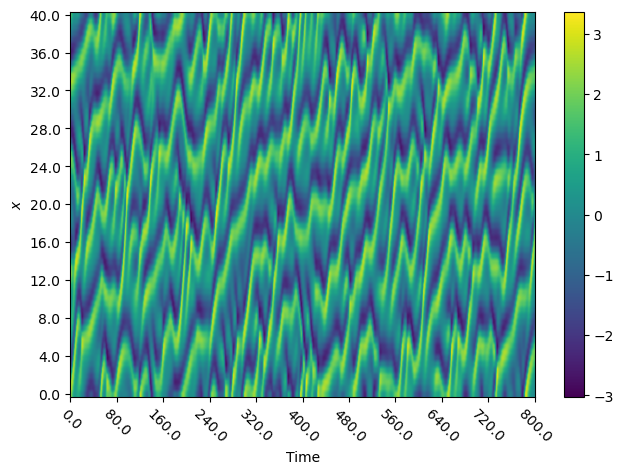

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

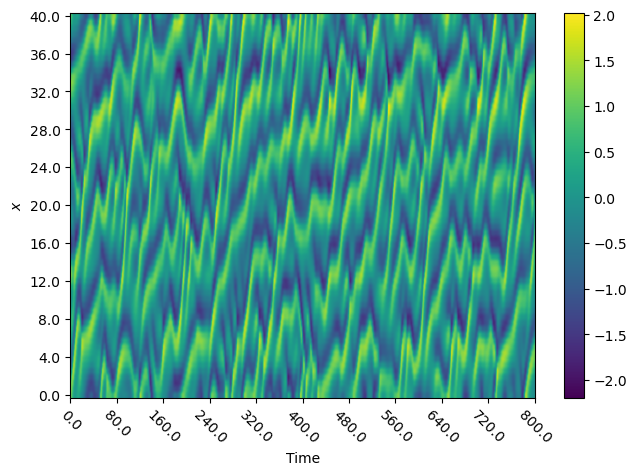

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [18]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

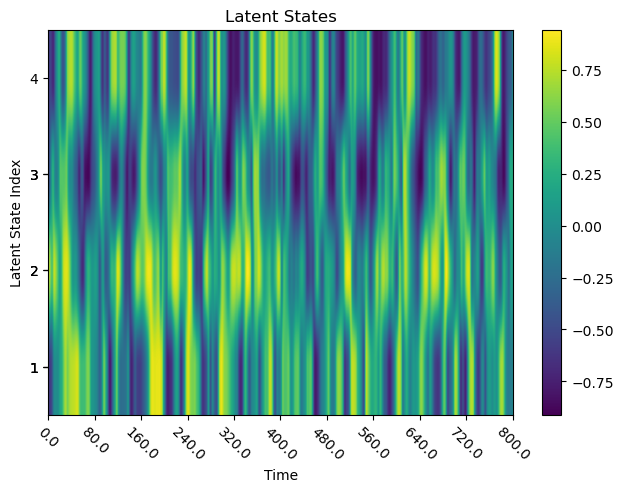

In [20]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 3
    num_timesteps_warmup = 50
    T_sample_input = (num_timesteps_warmup+0.1)*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [23]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [24]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.00001,
         'eta_high':0.00001,
          'eta_low':0.000001
    }
    epochs = 2000
    patience = 50  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))

In [25]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [26]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [27]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                T_input=T_sample_input,
                T_output=T_sample_output,
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            T_input=T_sample_input,
            T_output=T_sample_output,
        )
    save_path = dir_name_ARrnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ARrnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ARrnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)

In [28]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_ARrnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ARrnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [29]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    # the below two lines are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ARrnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=20,
        expected_epochs=50,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        # validation_split=val_split/(train_split+val_split),
        validation_data=(val_data_rnn_input, val_data_rnn_output),
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

Epoch 1/2000
95/95 [==============================] - ETA: 0s - loss: 0.1388 - tot_time: 0h 1m 36.4s

Epoch 1: val_loss improved from inf to 0.14730, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 96s 315ms/step - loss: 0.1388 - val_loss: 0.1473
Epoch 2/2000
95/95 [==============================] - ETA: 0s - loss: 0.1380 - tot_time: 0h 1m 58.5s

Epoch 2: val_loss did not improve from 0.14730
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1380 - val_loss: 0.1510
Epoch 3/2000
95/95 [==============================] - ETA: 0s - loss: 0.1374 - tot_time: 0h 2m 20.9s

Epoch 3: val_loss did not improve from 0.14730
 - saving 

Epoch 21/2000
95/95 [==============================] - ETA: 0s - loss: 0.1219 - tot_time: 0h 9m 4.1s

Epoch 21: val_loss did not improve from 0.13324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 235ms/step - loss: 0.1219 - val_loss: 0.1334
Epoch 22/2000
95/95 [==============================] - ETA: 0s - loss: 0.1214 - tot_time: 0h 9m 26.3s

Epoch 22: val_loss did not improve from 0.13324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1214 - val_loss: 0.1385
Epoch 23/2000
95/95 [==============================] - ETA: 0s - loss: 0.1211 - tot_time: 0h 9m 48.5s

Epoch 23: val_loss did not improve from 0.13324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossH

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1166 - val_loss: 0.1341
Epoch 43/2000
95/95 [==============================] - ETA: 0s - loss: 0.1164 - tot_time: 0h 17m 13.7s

Epoch 43: val_loss did not improve from 0.13097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1164 - val_loss: 0.1326
Epoch 44/2000
95/95 [==============================] - ETA: 0s - loss: 0.1162 - tot_time: 0h 17m 36.0s

Epoch 44: val_loss did not improve from 0.13097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 235ms/step - loss: 0.1162 - val_loss: 0.1349
Epoch 45/2000
95/95 [==================

Epoch 65/2000
95/95 [==============================] - ETA: 0s - loss: 0.1146 - tot_time: 0h 25m 23.5s

Epoch 65: val_loss did not improve from 0.13097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 235ms/step - loss: 0.1146 - val_loss: 0.1329
Epoch 66/2000
95/95 [==============================] - ETA: 0s - loss: 0.1146 - tot_time: 0h 25m 45.7s

Epoch 66: val_loss did not improve from 0.13097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1146 - val_loss: 0.1323
Epoch 67/2000
95/95 [==============================] - ETA: 0s - loss: 0.1145 - tot_time: 0h 26m 7.8s

Epoch 67: val_loss did not improve from 0.13097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/Lo

95/95 [==============================] - ETA: 0s - loss: 0.1138 - tot_time: 0h 33m 9.0s

Epoch 86: val_loss did not improve from 0.13003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1138 - val_loss: 0.1304
Epoch 87/2000
95/95 [==============================] - ETA: 0s - loss: 0.1138 - tot_time: 0h 33m 31.2s

Epoch 87: val_loss did not improve from 0.13003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1138 - val_loss: 0.1312
Epoch 88/2000
95/95 [==============================] - ETA: 0s - loss: 0.1137 - tot_time: 0h 33m 53.5s

Epoch 88: val_loss did not improve from 0.13003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesChe

95/95 [==============================] - ETA: 0s - loss: 0.1134 - tot_time: 0h 40m 55.7s

Epoch 107: val_loss did not improve from 0.12906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1134 - val_loss: 0.1306
Epoch 108/2000
95/95 [==============================] - ETA: 0s - loss: 0.1134 - tot_time: 0h 41m 17.9s

Epoch 108: val_loss did not improve from 0.12906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1134 - val_loss: 0.1291
Epoch 109/2000
95/95 [==============================] - ETA: 0s - loss: 0.1134 - tot_time: 0h 41m 40.1s

Epoch 109: val_loss did not improve from 0.12906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistor

95/95 [==============================] - ETA: 0s - loss: 0.1131 - tot_time: 0h 48m 40.9s

Epoch 128: val_loss did not improve from 0.12876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1131 - val_loss: 0.1291
Epoch 129/2000
95/95 [==============================] - ETA: 0s - loss: 0.1131 - tot_time: 0h 49m 2.9s

Epoch 129: val_loss did not improve from 0.12876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1131 - val_loss: 0.1293
Epoch 130/2000
95/95 [==============================] - ETA: 0s - loss: 0.1131 - tot_time: 0h 49m 25.2s

Epoch 130: val_loss did not improve from 0.12876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistori

Epoch 150/2000
95/95 [==============================] - ETA: 0s - loss: 0.1128 - tot_time: 0h 56m 49.2s

Epoch 150: val_loss did not improve from 0.12816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1128 - val_loss: 0.1298
Epoch 151/2000
95/95 [==============================] - ETA: 0s - loss: 0.1128 - tot_time: 0h 57m 11.2s

Epoch 151: val_loss did not improve from 0.12816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1128 - val_loss: 0.1298
Epoch 152/2000
95/95 [==============================] - ETA: 0s - loss: 0.1128 - tot_time: 0h 57m 33.4s

Epoch 152: val_loss did not improve from 0.12816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpo

95/95 [==============================] - ETA: 0s - loss: 0.1126 - tot_time: 1h 4m 57.0s

Epoch 172: val_loss did not improve from 0.12816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 236ms/step - loss: 0.1126 - val_loss: 0.1290
Epoch 173/2000
95/95 [==============================] - ETA: 0s - loss: 0.1125 - tot_time: 1h 5m 19.1s

Epoch 173: val_loss did not improve from 0.12816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1125 - val_loss: 0.1286
Epoch 174/2000
95/95 [==============================] - ETA: 0s - loss: 0.1125 - tot_time: 1h 5m 41.3s

Epoch 174: val_loss improved from 0.12816 to 0.12814, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/checkpoint
 - saving

Epoch 193/2000
95/95 [==============================] - ETA: 0s - loss: 0.1123 - tot_time: 1h 12m 43.8s

Epoch 193: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1123 - val_loss: 0.1285
Epoch 194/2000
95/95 [==============================] - ETA: 0s - loss: 0.1123 - tot_time: 1h 13m 5.8s

Epoch 194: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1123 - val_loss: 0.1289
Epoch 195/2000
95/95 [==============================] - ETA: 0s - loss: 0.1123 - tot_time: 1h 13m 28.0s

Epoch 195: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoi

Epoch 215/2000
95/95 [==============================] - ETA: 0s - loss: 0.1120 - tot_time: 1h 20m 51.9s

Epoch 215: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1120 - val_loss: 0.1292
Epoch 216/2000
95/95 [==============================] - ETA: 0s - loss: 0.1120 - tot_time: 1h 21m 14.1s

Epoch 216: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1120 - val_loss: 0.1275
Epoch 217/2000
95/95 [==============================] - ETA: 0s - loss: 0.1120 - tot_time: 1h 21m 36.3s

Epoch 217: val_loss did not improve from 0.12740
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 235ms/step - loss: 0.1118 - val_loss: 0.1271
Epoch 237/2000
95/95 [==============================] - ETA: 0s - loss: 0.1118 - tot_time: 1h 29m 1.0s

Epoch 237: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1118 - val_loss: 0.1274
Epoch 238/2000
95/95 [==============================] - ETA: 0s - loss: 0.1117 - tot_time: 1h 29m 23.1s

Epoch 238: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 232ms/step - loss: 0.1117 - val_loss: 0.1273
Epoch 239/2000
95/95 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1115 - val_loss: 0.1284
Epoch 259/2000
95/95 [==============================] - ETA: 0s - loss: 0.1115 - tot_time: 1h 37m 9.9s

Epoch 259: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 233ms/step - loss: 0.1115 - val_loss: 0.1280
Epoch 260/2000
95/95 [==============================] - ETA: 0s - loss: 0.1115 - tot_time: 1h 37m 32.2s

Epoch 260: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 0.1115 - val_loss: 0.1270
Epoch 261/2000
95/95 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 235ms/step - loss: 0.1113 - val_loss: 0.1274
Epoch 281/2000
95/95 [==============================] - ETA: 0s - loss: 0.1113 - tot_time: 1h 45m 20.0s

Epoch 281: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 236ms/step - loss: 0.1113 - val_loss: 0.1279
Epoch 282/2000
95/95 [==============================] - ETA: 0s - loss: 0.1113Restoring model weights from the end of the best epoch: 232.
 - tot_time: 1h 45m 42.2s

Epoch 282: val_loss did not improve from 0.12671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint
95/95 [==============================] - 22s 234ms/step - loss: 

In [30]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_ARrnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

24/24 [==============================] - 2s 69ms/step - loss: 0.1311


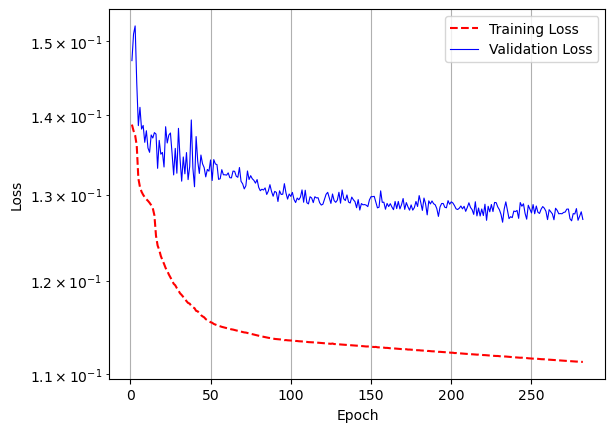

In [31]:
# plotting losses
dir_name_plot = dir_name_ARrnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_plot+'{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 391


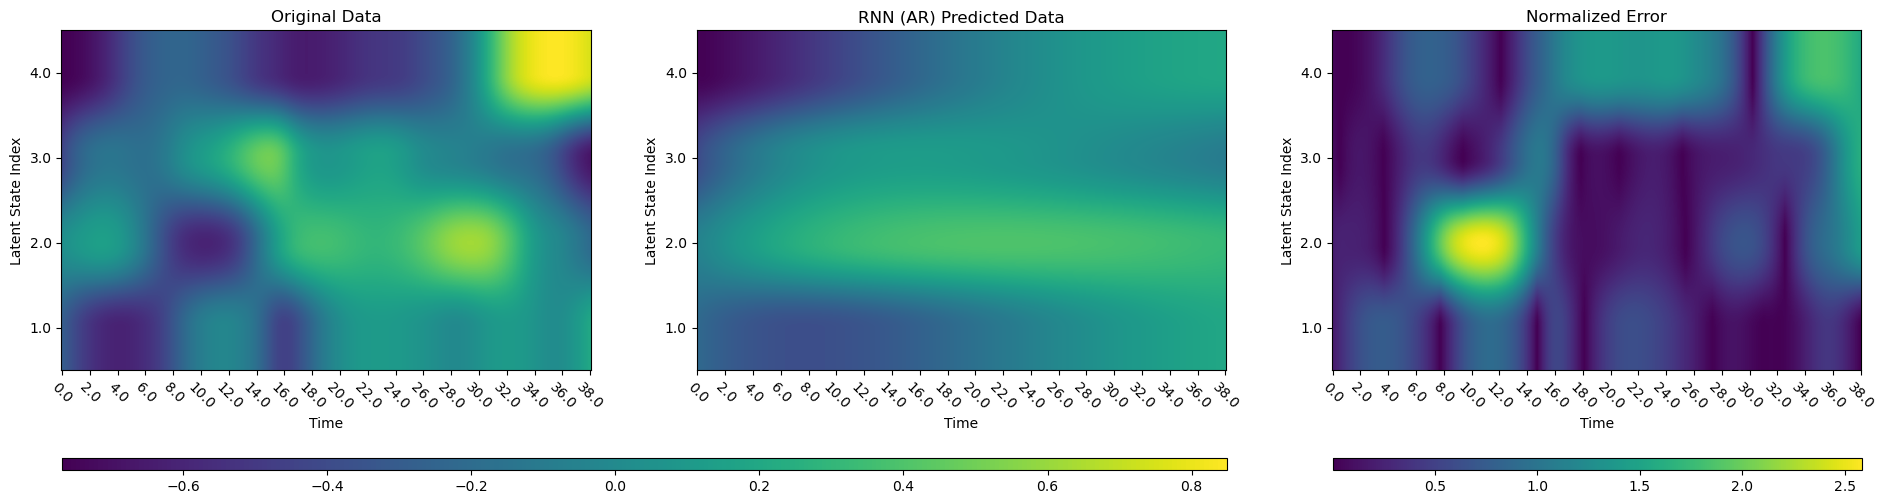

In [32]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ARrnn,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (AR) Predicted Data')

In [33]:
prediction.shape, data_out.shape

((1, 381, 4), (381, 4))

In [34]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 442


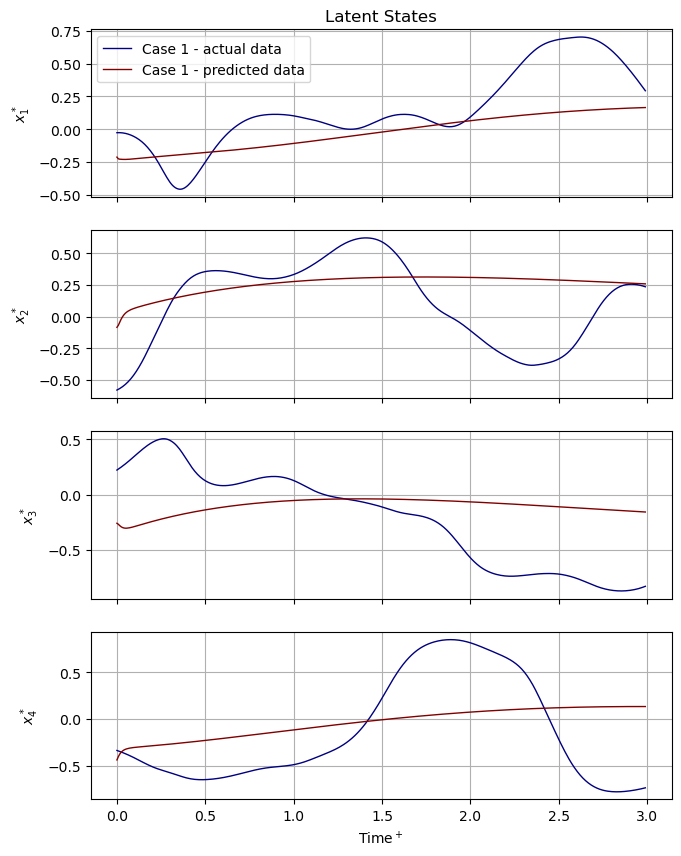


0.0


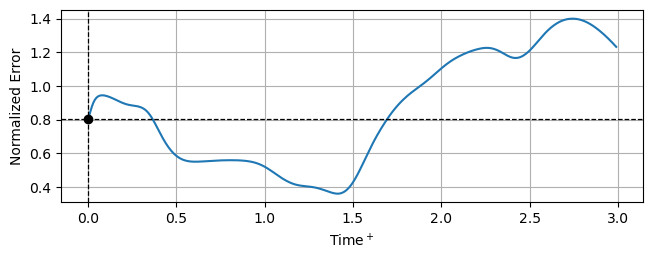

In [35]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
# for i in range(len(rnn_data_boundary_idx_arr)):
#     if data_idx < rnn_data_boundary_idx_arr[i]:
#         case_idx = i
#         break
case_idx = 0
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{}$'.format(i) for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error /= norm_sq_time_average(data_out)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.4

predhor_idx = np.where(error >= error_threshold)[0][0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()